In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Suppress a specific warning type
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [19]:
# Load the data
df = pd.read_json("Test/ergometer_500m.json")

In [20]:
# Define target variable (e.g., speed) and features (time)
X = df['split_calories'].values.reshape(-1, 1)  # Time as the independent variable

# Calcul de la vitesse en km/h (distance en km / temps en heures)
df['split_time_hours'] = df['split_time'] / 3600  # Conversion du temps en heures
df['speed_kmh'] = (0.5 / df['split_time_hours'])  # La distance est de 0.5 km (500m)
df['speed_category'] = pd.cut(df['speed_kmh'], bins=[0, 13.5, 15, 20], labels=[0, 1, 2])

y = df['speed_category']

In [21]:
class Classifier : 

    def __init__(
        self,
        X : np.ndarray,
        y : np.ndarray,
        n_per_class : int = 10
    ) -> None : 
            
        self.X_train, self.X_test, self.y_train,self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    def train(self) : 
        raise NotImplementedError("Please Implement this method")

    def predict(self) : 
        return self.model.predict(self.X_test)

    def accuracy(self) : 
        self.train()
        predicted_categories = self.predict()

        # print(predicted_categories)

        return len([i for i in range(len(predicted_categories)) if predicted_categories[i]==list(self.y_test)[i]]) / len(self.X_test)

    def finetune(self) : 
        raise NotImplementedError("Please Implement this method")

In [22]:
class RFC(Classifier) : 
    def __init__(
        self,
        X : np.ndarray,
        y : np.ndarray,
    ) -> None :
        super().__init__(X=X,y=y)
        self.model = RandomForestClassifier(n_estimators=100)

    def finetune(self) : 
        param_grid = {'n_estimators': [10, 50, 100, 200, 500]}

        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, scoring='accuracy')
        grid_search.fit(self.X_train, self.y_train)

        # Best parameters and score
        # print(f"Best n_estimators: {grid_search.best_params_}")
        # print(f"Best cross-validation score: {grid_search.best_score_}")

        return grid_search.best_params_['n_estimators'], grid_search.best_score_

    def train(self) : 
        n_est = self.finetune()[0]
        self.model = RandomForestClassifier(n_estimators=n_est)
        self.model.fit(self.X_train, self.y_train)

In [23]:
class LR(Classifier) : 
    def __init__(
        self,
        X : np.ndarray,
        y : np.ndarray,
    ) -> None :
        super().__init__(X=X,y=y)
        self.model = LogisticRegression()
    
    def finetune(self) : 

        # Define the hyperparameters to tune
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Type of regularization
            'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],  # Optimization algorithm
        }

        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, scoring='accuracy')
        grid_search.fit(self.X_train, self.y_train)

        # Best parameters and score
        # print(f"Best params: {grid_search.best_params_}")
        # print(f"Best cross-validation score: {grid_search.best_score_}")
        
        return grid_search.best_params_, grid_search.best_score_
    
    def train(self) : 
        params = self.finetune()[0]
        self.model = LogisticRegression(
            C = params['C'],
            penalty = params['penalty'],
            solver = params['solver']
        )
        self.model.fit(self.X_train, self.y_train)

In [30]:
class KNR(Classifier) : 
    def __init__(
        self,
        X : np.ndarray,
        y : np.ndarray,
    ) -> None :
        super().__init__(X=X,y=y)
        self.model = KNeighborsRegressor(n_neighbors=3)
    
    def finetune(self) : 
        # Define our candidate hyperparameters
        hp_candidates = [{'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'weights': ['uniform','distance'],'p':[1,2,5]}]

        # Define the hyperparameters to tune
        param_grid = {
            'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
            'weights': ['uniform', 'distance'],  # Weighting of neighbors
            'metric': ['minkowski', 'euclidean', 'manhattan'],  # Distance metric
            'p': [1, 2],  # Power parameter for Minkowski metric (only used if metric is 'minkowski')
        }

        # Perform Grid Search with cross-validation
        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, scoring='neg_mean_squared_error')
        grid_search.fit(self.X_train, self.y_train)

        # Best parameters and score
        # print(f"Best parameters: {grid_search.best_params_}")
        # print(f"Best cross-validation score: {grid_search.best_score_}")
        return grid_search.best_params_, grid_search.best_score_

    def train(self) : 
        params = self.finetune()[0]
        self.model = KNeighborsRegressor(
            n_neighbors = params['n_neighbors'],
            weights = params['weights'],
            metric = params['metric'],
            p = params['p']
        )
        self.model.fit(self.X_train, self.y_train)

In [31]:
class MNB(Classifier) : 
    def __init__(
        self,
        X : np.ndarray,
        y : np.ndarray,
    ) -> None :
        super().__init__(X=X,y=y)
        self.model = MultinomialNB()
    
    def finetune(self) : 
        # Define the hyperparameters to tune
        param_grid = {
            'alpha': [0.1, 0.5, 1, 10],  # Smoothing parameter
            'fit_prior': [True, False]    # Whether to learn class prior probabilities
        }

        # Perform Grid Search with cross-validation
        grid_search = GridSearchCV(estimator=self.model, param_grid=param_grid, scoring='accuracy')
        grid_search.fit(self.X_train, self.y_train)

        # Best parameters and score
        # print(f"Best parameters: {grid_search.best_params_}")
        # print(f"Best cross-validation score: {grid_search.best_score_}")
        return grid_search.best_params_, grid_search.best_score_

    def train(self) : 
        params = self.finetune()[0]
        self.model = MultinomialNB(
            alpha = params['alpha'],
            fit_prior = params['fit_prior'],
        )
        self.model.fit(self.X_train, self.y_train)

Accuracy: 0.9230769230769231


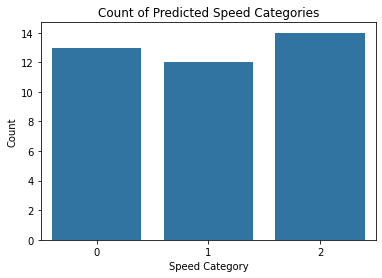

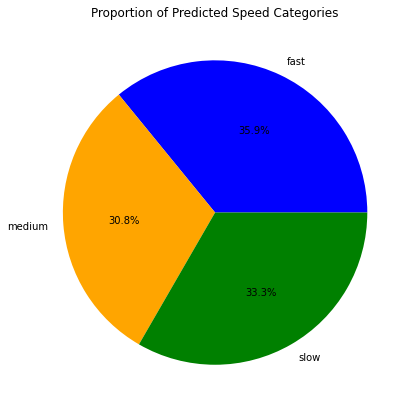

Accuracy: 0.8461538461538461


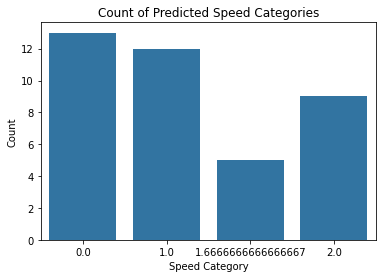

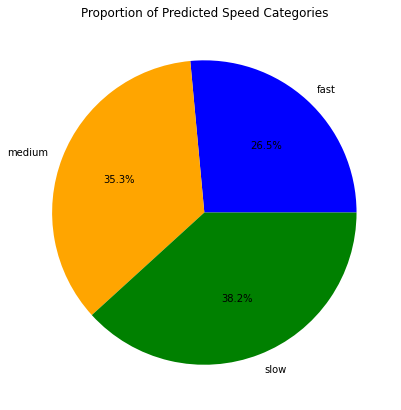

Accuracy: 0.38461538461538464


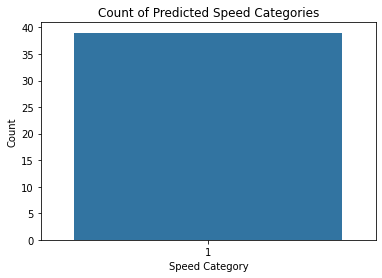

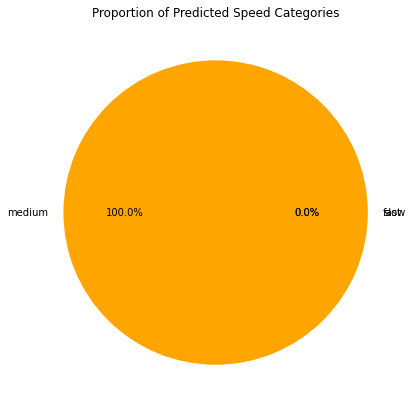

Accuracy: 0.8974358974358975


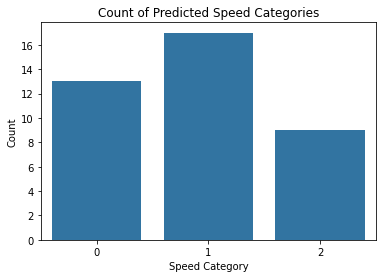

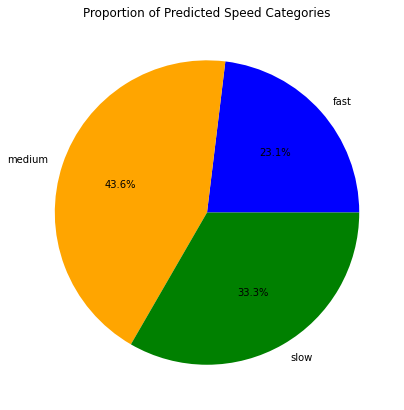

In [32]:
list_classifier = [RFC(X,y),KNR(X,y),MNB(X,y),LR(X,y)]

for classif in list_classifier : 
    model = classif 
    print("Accuracy:",model.accuracy())
    
    # Create a bar plot for the count of each predicted category
    sns.countplot(x=model.predict())
    plt.title('Count of Predicted Speed Categories')
    plt.xlabel('Speed Category')
    plt.ylabel('Count')
    plt.show()

    predicted_categories = model.predict()
    plt.figure(figsize=(7, 7))
    plt.pie([list(predicted_categories).count(2), list(predicted_categories).count(1),list(predicted_categories).count(0)],
            labels=['fast', 'medium','slow'], autopct='%1.1f%%', colors=['blue', 'orange','green'])
    plt.title('Proportion of Predicted Speed Categories')
    plt.show()